# Testing
## Bevölkerung nach Geburtsort und Geburtsland
Datum: 21.01.2022

### Settings

#### Importiere die notwendigen Packages

In [8]:
#pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly

In [64]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
from datetime import datetime
import geopandas as gpd
import folium 
import requests

import datetime
import time

In [65]:
import plotly.express as px


Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [66]:
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

In [67]:
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")

#### Datenimport

**Dataset auf INTEG Datenkatalog**: https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bev_bestand_jahr_gemeinde_land_geburtsort_od3380

**Dataset auf PROD Datenkatalog**: https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_gemeinde_land_geburtsort_od3380


In [68]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "prod";
print(status)

prod


In [69]:
# Filepath
if status == "prod":
    fp = r"//szh.loc/ssz/applikationen/OGD_Dropzone/DWH/bev_bestand_jahr_gemeinde_land_geburtsort_od3380/BEV338OD3380.csv"
else:
    fp = r"//szh.loc/ssz/applikationen/OGD_Dropzone/INT_DWH/bev_bestand_jahr_gemeinde_land_geburtsort_od3380/BEV338OD3380.csv"
#download from INT-Datacatalog:
# https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bfs_bevreg_todesursache-aggregiert_alter_geschlecht_seit1995_od3120/download/BEV312OD3120.csv
print(fp)

//szh.loc/ssz/applikationen/OGD_Dropzone/DWH/bev_bestand_jahr_gemeinde_land_geburtsort_od3380/BEV338OD3380.csv


In [70]:
# Read the data
data2betested = pd.read_csv(
    fp, 
    sep=',',
    parse_dates=True,
    #date_parser=lambda x: pd.to_datetime(x, format="%Y"), 
    #index_col="date_time",
    low_memory=False    
    )

#### Basic Tests

In der Folge ein paar erste Tests:

In [71]:
#type(data2betested)

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [72]:
data2betested.head(1)

,StichtagDatJahr,xkoord,ykoord,GebOrtSort,GebOrtLang,GebLandSort,GebLandLang,AnzBestWir
0,2020,2679530,1236588,1,Aeugst am Albis,8100,Schweiz,6


In [73]:
data2betested.dtypes

StichtagDatJahr      int64
xkoord             float64
ykoord             float64
GebOrtSort           int64
GebOrtLang          object
GebLandSort          int64
GebLandLang         object
AnzBestWir           int64
dtype: object

In [74]:
data2betested.shape

(1696, 8)

Beschreibe einzelne Attribute

In [75]:
data2betested.describe()

,StichtagDatJahr,xkoord,ykoord,GebOrtSort,GebLandSort,AnzBestWir
count,1696,1487,1487,1696,1696,1696
mean,2020,2654437,1214251,3707,8136,256
std,0,61281,47532,2979,106,3301
min,2020,2495123,1076471,1,8100,0
25%,2020,2611483,1183438,1058,8100,2
50%,2020,2655114,1226016,3312,8100,5
75%,2020,2698298,1252343,5173,8100,18
max,2020,2826234,1291100,9999,8995,126647


#### In diesem Datensatz insbesondere Missings bei Koordinaten?

Wie viele Nullwerte gibt es im Datensatz?

In [76]:
data2betested.isnull().sum()

StichtagDatJahr      0
xkoord             209
ykoord             209
GebOrtSort           0
GebOrtLang           0
GebLandSort          0
GebLandLang          0
AnzBestWir           0
dtype: int64

Viele Missings stammen daher, dass wir keine Koordinaten zu Ländern haben. Aus der Schweiz sollte es aber keine geben...

In [77]:
ch_missings = data2betested.query('GebLandLang=="Schweiz"')
ch_missings[ch_missings['xkoord'].isna()]

,StichtagDatJahr,xkoord,ykoord,GebOrtSort,GebOrtLang,GebLandSort,GebLandLang,AnzBestWir
629,2020,NaN,NaN,2430,Welschenrohr-Gänsbrunnen,8100,Schweiz,15
911,2020,NaN,NaN,3715,Muntogna da Schons,8100,Schweiz,1
1306,2020,NaN,NaN,5399,Verzasca,8100,Schweiz,1


**Achtung**

Wenn es hier Missings hat, dann bedeutet das, dass im SASA-Job wohl nicht die aktuellsten Koordinatenwerte übernommen wurden. Diese müssen jedes Jahr ca. Ende Januar von der Swisstopo aufbereitet werden. Bei uns macht das Mario, für die Gemeindegrenzen.


### Zwischenschritt optional - aktuellste Koordinaten für SASA generieren

Im folgenden generiere ich die notwendigen Gemeindemittelpunkte für SASA.

In [85]:
geo_path =r"//szh.loc/ssz/data/GIS/Daten/Vektor/_aktuell/swisstopo/swissBOUNDARIES3d_lv95/swissBOUNDARIES3D_1_3_TLM_HOHEITSGEBIET.shp"

imp_gdf_gemeindegrenzen = gpd.read_file(geo_path)
imp_gdf_gemeindegrenzen.head(2)
imp_gdf_gemeindegrenzen.dtypes


UUID            object
DATUM_AEND      object
DATUM_ERST      object
ERSTELL_J        int64
ERSTELL_M       object
REVISION_J       int64
REVISION_M      object
GRUND_AEND      object
HERKUNFT        object
HERKUNFT_J       int64
HERKUNFT_M      object
OBJEKTART       object
BEZIRKSNUM     float64
SEE_FLAECH     float64
REVISION_Q      object
NAME            object
KANTONSNUM     float64
ICC             object
EINWOHNERZ     float64
BFS_NUMMER       int64
GEM_TEIL        object
GEM_FLAECH     float64
SHN             object
geometry      geometry
dtype: object

<AxesSubplot:>

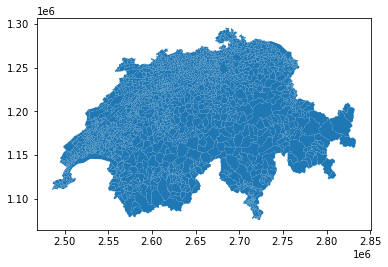

In [86]:
imp_gdf_gemeindegrenzen.plot()

In [87]:
#Gibt es bereits ein CRS? --> Ja
imp_gdf_gemeindegrenzen.crs is None

False

In [88]:
imp_gdf_gemeindegrenzen.crs

<Compound CRS: COMPD_CS["CH1903+ / LV95 + LN02 height",PROJCS["CH ...>
Name: CH1903+ / LV95 + LN02 height
Axis Info [cartesian|vertical]:
- [east]: Easting (metre)
- [north]: Northing (metre)
- [up]: Gravity-related height (metre)
Area of Use:
- undefined
Datum: CH1903+
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich
Sub CRS:
- CH1903+ / LV95
- LN02 height

#### Berechne die Centroid-Koordinaten aller Gemeinden

In [135]:
gdf_gemeindegrenzen=imp_gdf_gemeindegrenzen

gdf_gemeindegrenzen["X"] = gdf_gemeindegrenzen.centroid.x
gdf_gemeindegrenzen["Y"] = gdf_gemeindegrenzen.centroid.y
#gdf_gemeindegrenzen.head(2)

In [136]:
gdf_gemeindegrenzen.dtypes

UUID            object
DATUM_AEND      object
DATUM_ERST      object
ERSTELL_J        int64
ERSTELL_M       object
REVISION_J       int64
REVISION_M      object
GRUND_AEND      object
HERKUNFT        object
HERKUNFT_J       int64
HERKUNFT_M      object
OBJEKTART       object
BEZIRKSNUM     float64
SEE_FLAECH     float64
REVISION_Q      object
NAME            object
KANTONSNUM     float64
ICC             object
EINWOHNERZ     float64
BFS_NUMMER       int64
GEM_TEIL        object
GEM_FLAECH     float64
SHN             object
geometry      geometry
xkoord         float64
ykoord         float64
X              float64
Y              float64
dtype: object

In [139]:
exp_gdf_gemeindegrenzen = gdf_gemeindegrenzen[['X', 'Y','BFS_NUMMER','NAME','BEZIRKSNUM','KANTONSNUM','EINWOHNERZ','GEM_TEIL','GEM_FLAECH']]\
.query('GEM_TEIL == "0" or GEM_TEIL == "1"')

In [131]:
exp_gdf_gemeindegrenzen.sort_values('GEM_TEIL', ascending=False)

,X,Y,BFS_NUMMER,NAME,BEZIRKSNUM,KANTONSNUM,EINWOHNERZ,GEM_TEIL,GEM_FLAECH
871,2758318,1223817,7001,Vaduz,NaN,NaN,5696,1,1731
1058,2743309,1262128,3201,Häggenschwil,1721,17,1390,1,907
1871,2760670,1227805,7006,Planken,NaN,NaN,473,1,534
688,2731938,1249857,3401,Degersheim,1728,17,4121,1,1448
920,2756916,1214983,7003,Balzers,NaN,NaN,4642,1,1973
...,...,...,...,...,...,...,...,...,...
753,2644812,1222923,1128,Ettiswil,315,3,2730,0,1258
752,2682885,1291100,2951,Beggingen,1404,14,463,0,1258
751,2594847,1221200,383,Büren an der Aare,243,2,3584,0,1260
750,2559371,1217879,441,Renan (BE),241,2,927,0,1263


In [151]:
#Gibts noch n-Fache BFS-Nr?
test = exp_gdf_gemeindegrenzen.groupby(['BFS_NUMMER']).agg(AnzParts=('BFS_NUMMER', 'count')) 
#test.sort_values('AnzParts', ascending=False) 

In [152]:
exp_gdf_gemeindegrenzen.query('BFS_NUMMER == 5399')


,X,Y,BFS_NUMMER,NAME,BEZIRKSNUM,KANTONSNUM,EINWOHNERZ,GEM_TEIL,GEM_FLAECH
12,2705861,1128810,5399,Verzasca,2104,21,816,0,21848


In [153]:
exp_gdf_gemeindegrenzen.isnull().sum()

X               0
Y               0
BFS_NUMMER      0
NAME            0
BEZIRKSNUM    159
KANTONSNUM     13
EINWOHNERZ     17
GEM_TEIL        0
GEM_FLAECH      0
dtype: int64

#### Exportiere das File als Excel für SASA

Setze für das aktuelle Jahr bei den Daten den korrekten Wert ein

In [158]:
export_path =r"\\szh.loc\ssz\data\Auswertungen\Bevoelkerung\SASA\BEV338\KOOR_test.xlsx"

In [159]:
exp_gdf_gemeindegrenzen.to_excel(export_path,index=False)

### Weiter mit Plausi

Wandle die Spalte Jahr von Int zu **Datetime** um. Dies wird in den meisten Grafiken so benötigt.

In [45]:
data2betested['StichtagDatJahr']=pd.to_datetime(data2betested['StichtagDatJahr'], format='%Y')

#TO DO --> setze das Datum auf den 31.12. der Jahres.
#test=data2betested[['StichtagDatJahr']].date().replace(month=12, day=31)

data2betested

,StichtagDatJahr,xkoord,ykoord,GebOrtSort,GebOrtLang,GebLandSort,GebLandLang,AnzBestWir
0,2020-01-01,2679530,1236588,1,Aeugst am Albis,8100,Schweiz,6
1,2020-01-01,2676539,1237245,2,Affoltern am Albis,8100,Schweiz,1290
2,2020-01-01,2677695,1241150,3,Bonstetten,8100,Schweiz,5
3,2020-01-01,2683128,1233187,4,Hausen am Albis,8100,Schweiz,18
4,2020-01-01,2676560,1239448,5,Hedingen,8100,Schweiz,8
...,...,...,...,...,...,...,...,...
1691,2020-01-01,NaN,NaN,9999,Ausland,8612,Samoa,1
1692,2020-01-01,NaN,NaN,9999,Ausland,8614,Salomoninseln,2
1693,2020-01-01,NaN,NaN,9999,Ausland,8615,Tuvalu,1
1694,2020-01-01,NaN,NaN,9999,Ausland,8621,Amerikanisch-Samoa,1


Bereite die Daten für die Grafik unten vor

In [46]:
Jahre = data2betested.groupby("StichtagDatJahr")
len(Jahre)

1

In [13]:
for key, group in Jahre:
    print(key, len(group))

2020-01-01 00:00:00 1696


In [14]:
myJahr = "2020-01-01"
aktuellesJahr=Jahre.get_group(myJahr)   
aktuellesJahr.head(3)

,StichtagDatJahr,xkoord,ykoord,GebOrtSort,GebOrtLang,GebLandSort,GebLandLang,AnzBestWir
0,2020-01-01,2679530,1236588,1,Aeugst am Albis,8100,Schweiz,6
1,2020-01-01,2676539,1237245,2,Affoltern am Albis,8100,Schweiz,1290
2,2020-01-01,2677695,1241150,3,Bonstetten,8100,Schweiz,5


**Selektionen und Aggregationen**

Check this [Doku](https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/)

In [15]:
#test = data2betested.groupby(['StichtagDatJahr', 'AlterV20Kurz'])[['AnzBestWir']].agg()

# produces Pandas Series
    #data2betested.groupby(['StichtagDatJahr', 'KonOGDSort'])['AnzBestWir'].sum()
# Produces Pandas DataFrame
    #data2betested.groupby(['StichtagDatJahr', 'KonOGDSort'])[['AnzBestWir']].sum()
    
test = data2betested.groupby(
   ['RaumSort', 'RaumLang', 'StichtagDatJahr']
).agg(
    {
         'AnzBestWir':(sum),    # Sum --> (sum)
         'FlaecheS': 'max',  # get the first date per group
        'StichtagDatJahr': 'first'
    }
)
test.head()
    

KeyError: 'RaumSort'

**Einfache Visualisierungen zur Plausi**

Exploriere die Daten mit Pivottable.JS

In [25]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

In [26]:
mySelection = data2betested[(data2betested.StichtagDatJahr>"2011-01-01") & (data2betested.RaumKategorie=='Stadtquartier') & (data2betested.RaumSort<70)]

mySelection.head()



AttributeError: 'DataFrame' object has no attribute 'RaumKategorie'

In [ ]:
#mySelection = aktuellesJahr[["StatZoneSort","AnzBestWir"]]
#mySelection

In [27]:
# df_statzonen = df_statzonen[(df_statzonen.knr>0) & (df_statzonen.qname!="Hirslanden")]
#aktuellesJahr[[aktuellesJahr.KreisSort =7]])
highlight = alt.selection(type='single', on='mouseover',
                          fields=['RaumLang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(mySelection).encode(
    x='StichtagDatJahr:N',
    y='DichteS',
    color='RaumLang'
)

points = base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    width=700 , height=300
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1.5), alt.value(4))
).interactive()

points + lines

NameError: name 'mySelection' is not defined

In [28]:
alt.Chart(data2betested).mark_circle(size=60).encode(
    x='RaumLang', #QuarLang
    y='StichtagDatJahr',
    #color='AnzNat',
    #color=alt.Color('AnzNat', scale=alt.Scale(scheme='dark2')),
    color=alt.Color('DichteS', scale=alt.Scale(scheme='reds')),
    tooltip=['RaumLang','StichtagDatJahr','DichteS']
).interactive() # this makes the axes interactive: now you can zoom & pan




ValueError: DichteS encoding field is specified without a type; the type cannot be inferred because it does not match any column in the data.

alt.Chart(...)

Test: Choroplethenkarte

**Test: Choroplethenkarte**
Importiere die Geodaten als GeoJSON

In [29]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
# Filepath statzonen
input_stadtquartiere = r"//szh.loc/ssz/data/GIS/Daten/Vektor/_aktuell/stzh.adm_statistische_quartiere_map.json"
df_stadtquartiere = gpd.read_file(input_stadtquartiere)
df_stadtquartiere.head(2)
#df_stadtkreise.dtypes


,objectid,objid,qnr,qname,knr,kname,geometry
0,1,34,73,Hirslanden,7,Kreis 7,"POLYGON ((8.55670 47.36407, 8.55670 47.36406, ..."
1,2,33,83,Weinegg,8,Kreis 8,"POLYGON ((8.55671 47.36405, 8.55670 47.36405, ..."


Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [30]:
aktuellesJahr = data2betested[(data2betested.StichtagDatJahr=="2020-01-01") & (data2betested.RaumKategorie=='Stadtquartier') & (data2betested.RaumSort<500)]

aktuellesJahr.head(2)

AttributeError: 'DataFrame' object has no attribute 'RaumKategorie'

In [31]:
stats_agg_quartiere=aktuellesJahr
#stats_agg_quartiere=aktuellesJahr.groupby(['StichtagDatJahr', 'RaumLang', 'AnzBestWir'])['AnzNat'].sum()

#stats_agg_quartiere.head()

In [32]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name

stadtquartiere_shapes = df_stadtquartiere[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'RaumSort'})
#stadtquartiere_shapes = df_stadtquartiere[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarSort'})

# Merge with `merge` method on shared variable (stznr und StatZoneSort):
stadtquartiere_shapes_joined = stadtquartiere_shapes.merge(stats_agg_quartiere, on='RaumSort')

stadtquartiere_shapes_joined.head(3)


KeyError: 'RaumSort'

Importiere die Gemeindegrenzen der Schweiz und exportiere die Centroide dazu

<AxesSubplot:>

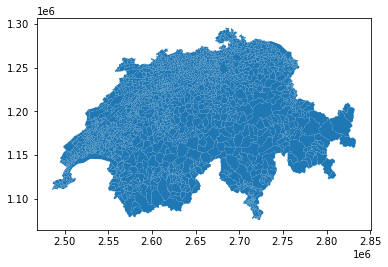

In [33]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
# Filepath statzonen
#\\szh.loc\ssz\data\GIS\Daten\Vektor\_aktuell\swisstopo\swissBOUNDARIES3d_lv95\swissBOUNDARIES3D_1_3_TLM_HOHEITSGEBIET.shp
input_gemeinden_CH = r"//szh.loc/ssz/data/GIS/Daten/Vektor/_aktuell/swisstopo/swissBOUNDARIES3d_lv95/swissBOUNDARIES3D_1_3_TLM_HOHEITSGEBIET.shp"
df_gemeinden_CH = gpd.read_file(input_gemeinden_CH)

df_gemeinden_CH.plot()
#df_stadtkreise.dtypes

In [36]:
#Berechne die Centroide

for i in range(0,len(df_gemeinden_CH)):
    df_gemeinden_CH.loc[i,'centroid_lon'] = df_gemeinden_CH.geometry.centroid.x.iloc[i]
    df_gemeinden_CH.loc[i,'centroid_lat'] = df_gemeinden_CH.geometry.centroid.y.iloc[i];
    
df_gemeinden_CH.head()   


,UUID,DATUM_AEND,DATUM_ERST,ERSTELL_J,ERSTELL_M,REVISION_J,REVISION_M,...,BFS_NUMMER,GEM_TEIL,GEM_FLAECH,SHN,geometry,centroid_lon,centroid_lat
0,{D5A9677C-FE38-44F6-B0E8-3177F6252C81},2020-11-03,2008-11-24,2000,1,2021,1,...,3762,0,43861,CH18433762,"POLYGON Z ((2812956.113 1194956.023 2980.122, ...",2816858,1184634
1,{B55F9EAE-EB69-4468-A41C-7BB28A6699EE},2020-11-03,2008-11-24,2006,1,2021,1,...,1631,0,43003,CH08001631,"POLYGON Z ((2715953.052 1184819.358 3402.836, ...",2724828,1198634
2,{AB2BA4A5-EB8C-40C7-A259-271DAC93C767},2020-11-03,2008-11-24,2000,1,2021,1,...,3746,0,34404,CH18433746,"POLYGON Z ((2803369.136 1191207.211 3111.081, ...",2802922,1176420
3,{550D0610-1EE3-4748-8F29-88072753FFDC},2020-11-03,2008-11-24,2000,1,2021,1,...,3543,0,32377,CH18413543,"POLYGON Z ((2757776.421 1165789.462 2730.100, ...",2766901,1155999
4,{5B0C1705-1D2B-4E53-9970-6BC3DE33A0F7},2020-11-03,2008-11-24,1997,1,2021,1,...,6037,0,30191,CH23036037,"POLYGON Z ((2588810.990 1085590.669 3576.258, ...",2589934,1095311


<AxesSubplot:>

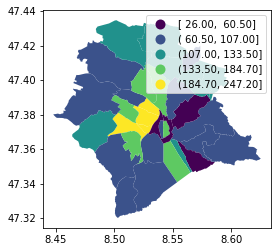

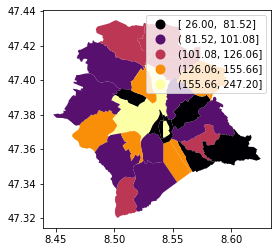

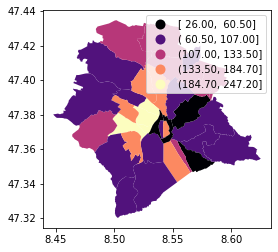

In [39]:
# Plot by StatZonen

stadtquartiere_shapes_joined.plot(column='DichteS', cmap='viridis', scheme='natural_breaks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

stadtquartiere_shapes_joined.plot(column='DichteS', cmap='inferno', scheme='quantiles', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html
stadtquartiere_shapes_joined.plot(column='DichteS', cmap='magma', scheme='fisherjenks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

**Sharepoint Status anpassen!**

Record auf Sharepoint in Bearbeitungsmodus öffnen: **[Link](http://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/EditForm.aspx?ID=831&Source=%2Forga%2Fssz%2Dprodukte%2FLists%2FSASA%5FOutputs)**